## Project Predictive Analytics: New York City Taxi Ride Duration Prediction

## **Marks: 40**
---------------

## **Context**
---------------

New York City taxi rides form the core of the traffic in the city of New York. The many rides taken every day by New Yorkers in the busy city can give us a great idea of traffic times, road blockages, and so on. A typical taxi company faces a common problem of efficiently assigning the cabs to passengers so that the service is hassle-free. One of the main issues is predicting the duration of the current ride so it can predict when the cab will be free for the next trip. Here the data set contains various information regarding the taxi trips, its duration in New York City. We will apply different techniques here to get insights into the data and determine how different variables are dependent on the Trip Duration.

-----------------
## **Objective**
-----------------

- To Build a predictive model, for predicting the duration for the taxi ride. 
- Use Automated feature engineering to create new features

-----------------
## **Dataset**
-----------------

The ``trips`` table has the following fields
* ``id`` which uniquely identifies the trip
* ``vendor_id`` is the taxi cab company - in our case study we have data from three different cab companies
* ``pickup_datetime`` the time stamp for pickup
* ``dropoff_datetime`` the time stamp for drop-off
* ``passenger_count`` the number of passengers for the trip
* ``trip_distance`` total distance of the trip in miles 
* ``pickup_longitude`` the longitude for pickup
* ``pickup_latitude`` the latitude for pickup
* ``dropoff_longitude``the longitude of dropoff 
* ``dropoff_latitude`` the latitude of dropoff
* ``payment_type`` a numeric code signifying how the passenger paid for the trip. 1= Credit card 2= Cash 3= No charge 4= Dispute 5= Unknown 6= Voided
* ``trip_duration`` this is the duration we would like to predict using other fields 
* ``pickup_neighborhood`` a one or two letter id of the neighborhood where the trip started
* ``dropoff_neighborhood`` a one or two letter id of the neighborhood where the trip ended



### We will do the following steps:
  * Install the dependencies
  * Load the data as pandas dataframe
  * Perform EDA on the dataset
  * Build features with Deep Feature Synthesis using the [featuretools](https://featuretools.com) package. We will start with simple features and incrementally improve the feature definitions and examine the accuracy of the system

#### Uncomment the code given below, and run the line of code to install featuretools library

In [1]:
# Uncomment the code given below, and run the line of code to install featuretools library

!pip install featuretools==0.27.0

### Note: If !pip install featuretools doesn't work, please install using the anaconda prompt by typing the following command in anaconda prompt
      conda install -c conda-forge featuretools==0.27.0

### Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Feataurestools for feature engineering
import featuretools as ft

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Importing gradient boosting regressor, to make prediction
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

#importing primitives
from featuretools.primitives import (Minute, Hour, Day, Month,
                                     Weekday, IsWeekend, Count, Sum, Mean, Median, Std, Min, Max)

print(ft.__version__)
%load_ext autoreload
%autoreload 2

0.27.0


In [235]:
# set global random seed
np.random.seed(40)

# To load the dataset
def load_nyc_taxi_data():
    trips = pd.read_csv('trips.csv',
                        parse_dates=["pickup_datetime","dropoff_datetime"],
                        dtype={'vendor_id':"category",'passenger_count':'int64'},
                        encoding='utf-8')
    trips["payment_type"] = trips["payment_type"].apply(str)
    trips = trips.dropna(axis=0, how='any', subset=['trip_duration'])

    pickup_neighborhoods = pd.read_csv("pickup_neighborhoods.csv", encoding='utf-8')
    dropoff_neighborhoods = pd.read_csv("dropoff_neighborhoods.csv", encoding='utf-8')

    return trips, pickup_neighborhoods, dropoff_neighborhoods

### To preview first five rows. 
def preview(df, n=5):
    """return n rows that have fewest number of nulls"""
    order = df.isnull().sum(axis=1).sort_values().head(n).index
    return df.loc[order]



#to compute features using automated feature engineering. 
def compute_features(features, cutoff_time):
    # shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix


#to generate train and test dataset
def get_train_test_fm(feature_matrix, percentage):
    nrows = feature_matrix.shape[0]
    head = int(nrows * percentage)
    tail = nrows-head
    X_train = feature_matrix.head(head)
    y_train = X_train['trip_duration']
    X_train = X_train.drop(['trip_duration'], axis=1)
    imp = SimpleImputer()
    X_train = imp.fit_transform(X_train)
    X_test = feature_matrix.tail(tail)
    y_test = X_test['trip_duration']
    X_test = X_test.drop(['trip_duration'], axis=1)
    X_test = imp.transform(X_test)

    return (X_train, y_train, X_test,y_test)



#to see the feature importance of variables in the final model
def feature_importances(model, feature_names, n=5):
    importances = model.feature_importances_
    zipped = sorted(zip(feature_names, importances), key=lambda x: -x[1])
    for i, f in enumerate(zipped[:n]):
        print("%d: Feature: %s, %.3f" % (i+1, f[0], f[1]))

### Load the Datasets

In [236]:
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_taxi_data()
preview(trips, 10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,2,2016-01-01 00:00:19,2016-01-01 00:06:31,3,1.32,-73.961258,40.796200,-73.950050,40.787312,2,372.0,AH,C
649598,679634,1,2016-04-30 11:45:59,2016-04-30 11:47:47,1,0.50,-73.994919,40.755226,-74.000351,40.747917,1,108.0,D,AG
649599,679635,2,2016-04-30 11:46:04,2016-04-30 11:47:41,2,0.33,-73.978935,40.777172,-73.981888,40.773136,2,97.0,AV,AV
649600,679636,2,2016-04-30 11:46:39,2016-04-30 11:58:02,1,1.78,-73.998207,40.745201,-73.990265,40.729023,2,683.0,AP,H
649601,679637,2,2016-04-30 11:46:44,2016-04-30 11:55:42,1,1.40,-73.987129,40.739429,-74.007370,40.743511,2,538.0,R,Q
649602,679638,2,2016-04-30 11:47:30,2016-04-30 11:54:00,1,1.12,-73.942375,40.790768,-73.952095,40.777145,2,390.0,J,AM
649603,679639,1,2016-04-30 11:47:38,2016-04-30 11:57:22,2,1.90,-73.960800,40.769920,-73.978966,40.785698,1,584.0,K,I
649604,679640,1,2016-04-30 11:47:49,2016-04-30 12:01:05,1,4.30,-74.013885,40.709515,-73.987213,40.722343,2,796.0,AU,AC
649605,679641,1,2016-04-30 11:48:17,2016-04-30 12:01:02,1,2.90,-73.975426,40.757584,-73.999016,40.722027,1,765.0,A,X
649606,679642,1,2016-04-30 11:49:44,2016-04-30 12:00:03,1,1.30,-73.989815,40.750454,-74.000473,40.762352,2,619.0,D,P


### Display first five rows

In [237]:
trips.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,2,2016-01-01 00:00:19,2016-01-01 00:06:31,3,1.32,-73.961258,40.796200,-73.950050,40.787312,2,372.0,AH,C
1,1,2,2016-01-01 00:01:45,2016-01-01 00:27:38,1,13.70,-73.956169,40.707756,-73.939949,40.839558,1,1553.0,Z,S
2,2,1,2016-01-01 00:01:47,2016-01-01 00:21:51,2,5.30,-73.993103,40.752632,-73.953903,40.816540,2,1204.0,D,AL
3,3,2,2016-01-01 00:01:48,2016-01-01 00:16:06,1,7.19,-73.983009,40.731419,-73.930969,40.808460,2,858.0,AT,J
4,4,1,2016-01-01 00:02:49,2016-01-01 00:20:45,2,2.90,-74.004631,40.747234,-73.976395,40.777237,1,1076.0,AG,AV


### Display info of the dataset

In [238]:
#checking the info of the dataset
trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974409 entries, 0 to 974408
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    974409 non-null  int64         
 1   vendor_id             974409 non-null  category      
 2   pickup_datetime       974409 non-null  datetime64[ns]
 3   dropoff_datetime      974409 non-null  datetime64[ns]
 4   passenger_count       974409 non-null  int64         
 5   trip_distance         974409 non-null  float64       
 6   pickup_longitude      974409 non-null  float64       
 7   pickup_latitude       974409 non-null  float64       
 8   dropoff_longitude     974409 non-null  float64       
 9   dropoff_latitude      974409 non-null  float64       
 10  payment_type          974409 non-null  object        
 11  trip_duration         974409 non-null  float64       
 12  pickup_neighborhood   974409 non-null  object        
 13 

- There are 974409 non null values in the dataset

### Check the number of unique values in the dataset.

In [239]:
# Check the uniques values in each columns
trips.nunique()

id                      974409
vendor_id                    2
pickup_datetime         939015
dropoff_datetime        938873
passenger_count              8
trip_distance             2503
pickup_longitude         20222
pickup_latitude          40692
dropoff_longitude        26127
dropoff_latitude         50077
payment_type                 4
trip_duration             3607
pickup_neighborhood         49
dropoff_neighborhood        49
dtype: int64

**Write your answers here:_____**
- vendor_id has only 2 unique values, implies there are only 2 major taxi vendors are there. 
- Passenger count has 8 unique values and payment type have 4. 
- There are 49 neighborhood in the dataset, from where either a pickup or dropoff is happening. 

### Question 1 : Check summary statistics of the dataset (1 Mark)

In [240]:
#chekcing the descriptive stats of the data

#Remove _________ and complete the code

trips.describe()

,id,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,9.744090e+05,974409.000000,974409.000000,974409.000000,974409.000000,974409.000000,974409.000000,974409.000000
mean,5.096223e+05,1.664010,2.734356,-73.973275,40.752475,-73.972825,40.753046,797.702753
std,2.944916e+05,1.314975,3.307038,0.035702,0.026668,0.031348,0.029151,576.802176
min,0.000000e+00,0.000000,0.000000,-74.029846,40.630268,-74.029945,40.630009,0.000000
25%,2.545210e+05,1.000000,1.000000,-73.991058,40.739689,-73.990356,40.738792,389.000000
50%,5.093100e+05,1.000000,1.640000,-73.981178,40.755390,-73.979156,40.755650,646.000000
75%,7.647430e+05,2.000000,2.990000,-73.966888,40.768929,-73.962769,40.770454,1040.000000
max,1.020002e+06,9.000000,502.800000,-73.770508,40.849911,-73.770020,40.849998,3606.000000


**Write your answers here:**

The average number of passengers is 1, something that usually happens in big cities. Biggest number of passangers was 9, implying a larger taxi must have been used. The minimum number of 0 looks odd, perhaps either a passenger changed his / her mind about the ride or some data anomaly.

The average distance was 1.64 miles, with the largest distance being 503 miles. Given there is no similar anomalous longitude or latitude reading, the large distance is more likely someone using the same taxi to drive around multiple destinations within New York City and not an interstate ride. We investigate this further in 2.1 below.

Longitude and Latitude readings are around the -73.77 to -74.03 range and 40.63 to 40.85 range respectively, which makes sense as longitude of New York City is -73.94 and latitude is 40.73 according to Google.

Trip Duration was 646 seconds on average, with the longest one being 3606 seconds (just over 1 hour). This could again be a long trip or simply a bad traffic jam.

Due to the large outliers: passenger count, trip distance and therefore trip duration all have larger standard deviations relative to their means. 

#### Checking for the rows for which trip_distance is 0

In [241]:
#Chekcing the rows where trip distance is 0
trips[trips['trip_distance']==0]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
852,880,1,2016-01-01 02:15:56,2016-01-01 02:16:17,1,0.0,-74.002586,40.750298,-74.002861,40.750446,2,21.0,AG,AG
1079,1116,1,2016-01-01 03:01:10,2016-01-01 03:03:26,1,0.0,-73.987831,40.728558,-73.988747,40.727280,3,136.0,H,H
1408,1455,2,2016-01-01 04:09:43,2016-01-01 04:10:48,1,0.0,-73.985893,40.763649,-73.985741,40.763672,2,65.0,AR,AR
1440,1488,1,2016-01-01 04:16:54,2016-01-01 04:16:57,1,0.0,-74.014198,40.709988,-74.014198,40.709988,3,3.0,AU,AU
1510,1558,1,2016-01-01 04:36:03,2016-01-01 04:36:16,1,0.0,-73.952507,40.817329,-73.952499,40.817322,2,13.0,AL,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972967,1018490,1,2016-06-30 19:09:44,2016-06-30 19:22:21,1,0.0,-73.945480,40.751400,-73.945496,40.751549,2,757.0,AN,AN
973384,1018928,2,2016-06-30 20:35:08,2016-06-30 20:35:10,1,0.0,-73.983864,40.693813,-73.983910,40.693817,1,2.0,AS,AS
973555,1019105,2,2016-06-30 21:13:50,2016-06-30 21:14:05,1,0.0,-74.008789,40.708740,-74.008659,40.708858,1,15.0,AU,AU
973607,1019159,2,2016-06-30 21:24:23,2016-06-30 21:37:40,1,0.0,-73.974510,40.778297,-73.977272,40.754047,1,797.0,I,AD


**Write your answers here:_____**
- We can observe that, where trip distance is 0 trip duration is not 0, hence we can replace those values. 
- There are 3807 such rows

#### Replacing the 0 values with median of the trip distance

In [242]:
trips['trip_distance']=trips['trip_distance'].replace(0,trips['trip_distance'].median())

In [243]:
trips[trips['trip_distance']==0].count()

id                      0
vendor_id               0
pickup_datetime         0
dropoff_datetime        0
passenger_count         0
trip_distance           0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
payment_type            0
trip_duration           0
pickup_neighborhood     0
dropoff_neighborhood    0
dtype: int64

#### Checking for the rows for which trip_duration is 0

In [244]:
trips[trips['trip_duration']==0].head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
44446,46325,1,2016-01-10 00:48:55,2016-01-10 00:48:55,1,1.20,-73.968842,40.766972,-73.968842,40.766972,3,0.0,AK,AK
121544,126869,2,2016-01-26 00:07:47,2016-01-26 00:07:47,6,4.35,-73.986694,40.739815,-73.956139,40.732872,1,0.0,R,Z
142202,148598,1,2016-01-30 00:00:29,2016-01-30 00:00:29,1,1.64,-73.989578,40.743877,-73.989578,40.743877,2,0.0,AO,AO
172653,180414,1,2016-02-04 19:23:45,2016-02-04 19:23:45,1,0.40,-73.990868,40.751106,-73.990868,40.751106,2,0.0,D,D
173013,180795,1,2016-02-04 20:23:10,2016-02-04 20:23:10,1,0.80,-73.977661,40.752968,-73.977661,40.752968,2,0.0,AD,AD


**Write your answers here:_____**
- We can observe that, where trip distance is 0 trip duration is not 0, hence we can replace those values. 

In [245]:
trips['trip_duration']=trips['trip_duration'].replace(0,trips['trip_duration'].median())

In [246]:
trips[trips['trip_duration']==0].count()

id                      0
vendor_id               0
pickup_datetime         0
dropoff_datetime        0
passenger_count         0
trip_distance           0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
payment_type            0
trip_duration           0
pickup_neighborhood     0
dropoff_neighborhood    0
dtype: int64

### Question 2: Univariate Analysis

### Question 2.1: Build histogram for numerical columns (1 Marks)

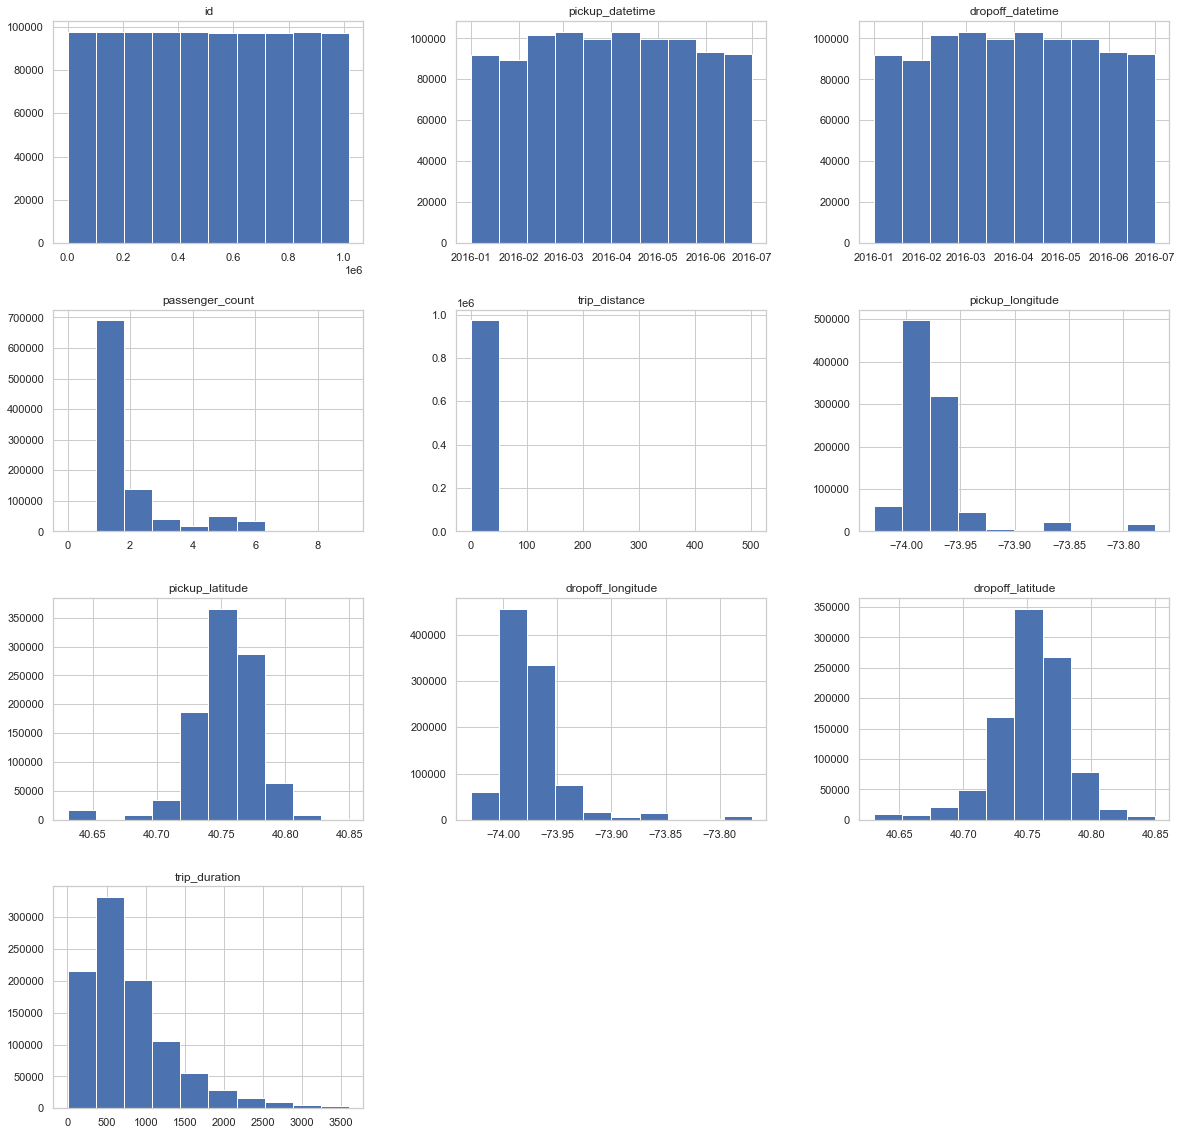

In [247]:
#Remove _________ and complete the code
trips.hist(figsize=(20, 20))
plt.show()

**Write your answers here:**

Passenger Count, Trip Duration and Distance are all right skewed, with Trip Distance being particularly odd as the overwhelming majority of rides is < 50 miles. This makes the 503 mile long ride particularly odd, requiring further investigation with a Boxplot below.

Pickup and drop-off latutides are roughly normally distributed. Pickup and drop-off longitudes are somewhat more right skewed.

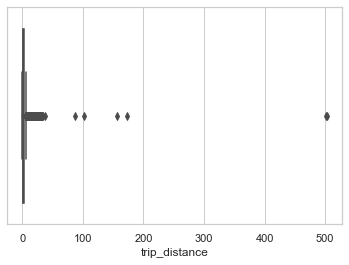

In [248]:
sns.boxplot(x=trips['trip_distance'])
plt.show()

- We can see there is an extreme outlier in the dataset, we drop investigate it further

In [249]:
trips[trips['trip_distance']>100]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
171143,178815,1,2016-02-04 14:05:10,2016-02-04 14:56:37,1,156.2,-73.979149,40.765499,-73.782806,40.644009,1,3087.0,AR,G
248346,259490,1,2016-02-18 09:48:06,2016-02-18 09:50:27,1,501.4,-73.980087,40.782185,-73.981468,40.778519,2,141.0,I,AV
525084,548884,1,2016-04-07 21:19:03,2016-04-07 22:03:17,3,172.3,-73.783340,40.644176,-73.936028,40.737762,2,2654.0,G,AN
530340,554389,1,2016-04-08 19:19:32,2016-04-08 19:41:33,2,502.8,-73.995461,40.724884,-73.986099,40.762108,1,1321.0,X,AA
828650,867217,1,2016-06-02 21:30:17,2016-06-02 21:36:47,2,101.0,-73.961586,40.800968,-73.950165,40.802193,2,390.0,AH,J


- We can observe that, there are 2 observation>500, and there is a huge gap in the trip duration for them.
- Covering 501.4 distance in 141 sec, is not possible, it is better we can clip these values to 50. 

#### Clipping the outliers of trip distance to 50

In [250]:
trips['trip_distance']=trips['trip_distance'].clip(trips['trip_distance'].min(),50)

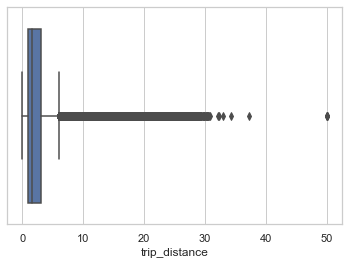

In [251]:
sns.boxplot(x=trips['trip_distance'])
plt.show()

### Question 2.2 Plotting countplot for Passenger_count (1 Marks)

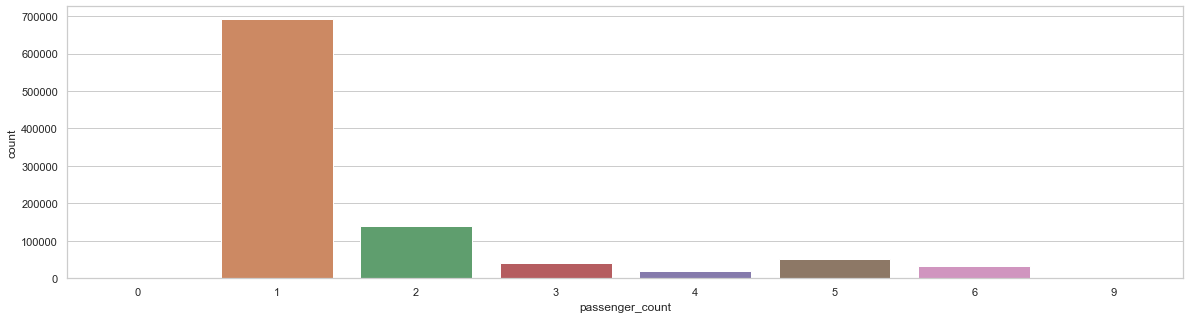

In [252]:
#Remove _________ and complete the code

import seaborn as sns
plt.figure(figsize=(20,5))
sns.countplot(data=trips, x=trips['passenger_count'])
plt.show()

In [253]:
trips.passenger_count.value_counts(normalize=True)

1    0.709334
2    0.143419
5    0.053409
3    0.041140
6    0.033334
4    0.019338
0    0.000025
9    0.000002
Name: passenger_count, dtype: float64

**Write your answers here:**
This count plot re-interates what was previously observed by the histogram: the biggest number of taxi rides was for 1 person (perhaps for business). The next largest is for two people (perhaps married couples). Whilst 9 does seem very large, there are larger taxis that can take that many people, so I do not think it is an outlier, more like a large group of partying people!


### Question 2.3 Plotting countplot for pickup_neighborhood and dropoff_neighborhood (2 Marks)

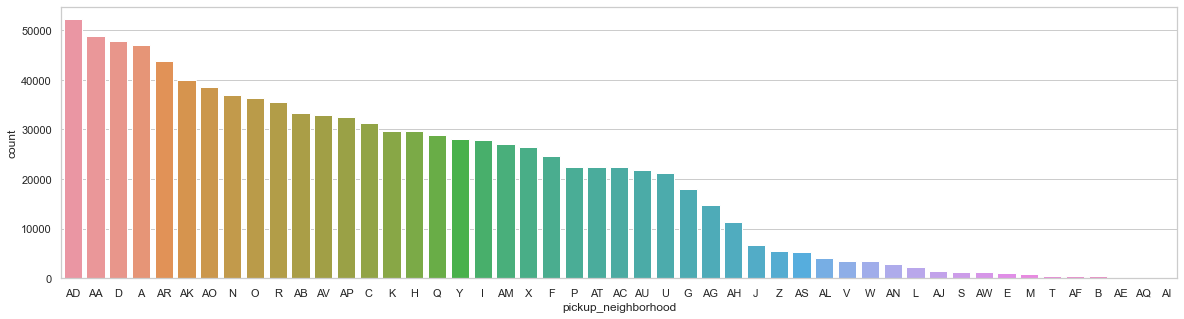

In [254]:
#Remove _________ and complete the code
plt.figure(figsize=(20,5))
sns.countplot(data=trips, 
              x=trips['pickup_neighborhood'], 
              order=trips['pickup_neighborhood'].value_counts().index)
plt.show()

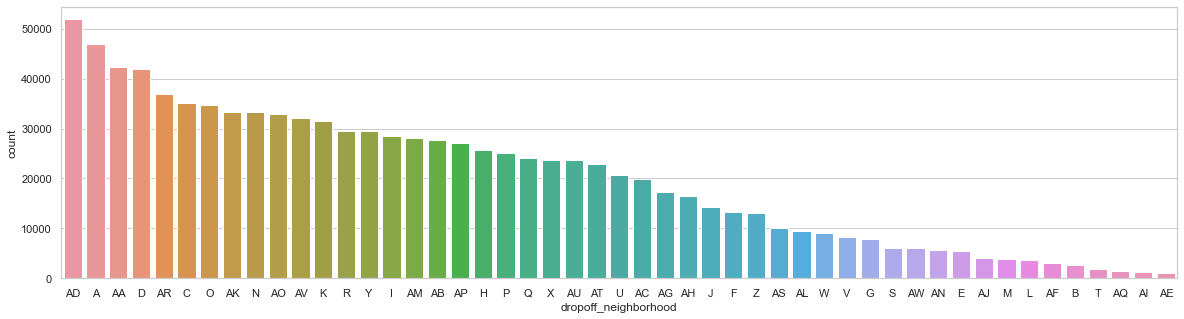

In [255]:
#Remove _________ and complete the code
plt.figure(figsize=(20,5))
sns.countplot(data=trips, 
              x=trips['dropoff_neighborhood'],
              order=trips['dropoff_neighborhood'].value_counts().index)
plt.show()

**Write your answers here:**
We can see that both the 5 most popular pickup and drop-off locations in New York City are AD, AA, D, A and AR. 

In [256]:
pickup_neighborhoods.head()

,neighborhood_id,latitude,longitude
0,AH,40.804349,-73.961716
1,Z,40.715828,-73.954298
2,D,40.750179,-73.992557
3,AT,40.729670,-73.981693
4,AG,40.749843,-74.003458


### Bivariate analysis

#### Plot a scatter plot for trip distance and trip duration

<AxesSubplot:xlabel='trip_distance', ylabel='trip_duration'>

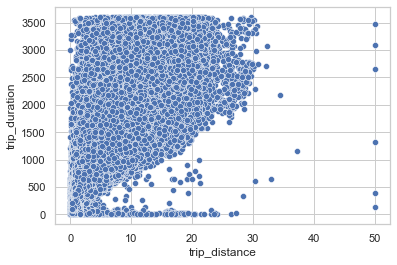

In [257]:
sns.scatterplot(x=trips['trip_distance'],y=trips['trip_duration'])

- There is some positive correlation between trip_distance and trip_duration.

<AxesSubplot:xlabel='passenger_count', ylabel='count'>

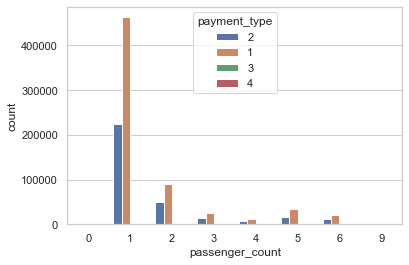

In [258]:
sns.countplot(x=trips['passenger_count'],hue=trips['payment_type'])

- There is no such specific pattern can be observed.

### Step 2: Prepare the Data

Lets create entities and relationships. The three entities in this data are 
* trips 
* pickup_neighborhoods
* dropoff_neighborhoods

This data has the following relationships
* pickup_neighborhoods --> trips (one neighborhood can have multiple trips that start in it. This means pickup_neighborhoods is the ``parent_entity`` and trips is the child entity)
* dropoff_neighborhoods --> trips (one neighborhood can have multiple trips that end in it. This means dropoff_neighborhoods is the ``parent_entity`` and trips is the child entity)

In <a <href="https://www.featuretools.com/"><featuretools (automated feature engineering software package)/></a>, we specify the list of entities and relationships as follows: 


### Question 3: Define entities and relationships for the Deep Feature Synthesis (2 Marks)

In [259]:
#Remove _________ and complete the codeV

entities = {
        "trips": (trips, "id", 'pickup_datetime' ),
        "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
        "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
        }

#Remove _________ and complete the code
relationships = [("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                 ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")]

Next, we specify the cutoff time for each instance of the target_entity, in this case ``trips``.This timestamp represents the last time data can be used for calculating features by DFS. In this scenario, that would be the pickup time because we would like to make the duration prediction using data before the trip starts. 

For the purposes of the case study, we choose to only select trips that started after January 12th, 2016. 

In [260]:
cutoff_time = trips[['id', 'pickup_datetime']]
cutoff_time = cutoff_time[cutoff_time['pickup_datetime'] > "2016-01-12"]
preview(cutoff_time, 10)

,id,pickup_datetime
54031,56311,2016-01-12 00:00:25
667608,698423,2016-05-03 17:59:59
667609,698424,2016-05-03 18:00:52
667610,698425,2016-05-03 18:01:06
667611,698426,2016-05-03 18:01:11
667612,698427,2016-05-03 18:01:12
667613,698428,2016-05-03 18:01:12
667614,698429,2016-05-03 18:01:24
667615,698430,2016-05-03 18:01:36
667616,698431,2016-05-03 18:01:39


### Step 3: Create baseline features using Deep Feature Synthesis

Instead of manually creating features, such as "month of pickup datetime", we can let DFS come up with them automatically. It does this by 
* interpreting the variable types of the columns e.g categorical, numeric and others 
* matching the columns to the primitives that can be applied to their variable types
* creating features based on these matches

**Create transform features using transform primitives**

As we described in the video, features fall into two major categories, ``transform`` and ``aggregate``. In featureools, we can create transform features by specifying ``transform`` primitives. Below we specify a ``transform`` primitive called ``weekend`` and here is what it does:

* It can be applied to any ``datetime`` column in the data. 
* For each entry in the column, it assess if it is a ``weekend`` and returns a boolean. 

In this specific data, there are two ``datetime`` columns ``pickup_datetime`` and ``dropoff_datetime``. The tool automatically creates features using the primitive and these two columns as shown below. 

### Question 4: Creating a baseline model with only 1 transform primitive (10 Marks)

**Question: 4.1 Define transform primitive for weekend and define features using dfs?** 

In [261]:
#Remove _________ and complete the code
trans_primitives = [IsWeekend]

#Remove _________ and complete the code
#Pass the entities and relationships already created above
features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

*If you're interested about parameters to DFS such as `ignore_variables`, you can learn more about these parameters [here](https://docs.featuretools.com/generated/featuretools.dfs.html#featuretools.dfs)*
<p>Here are the features created.</p>

In [262]:
print ("Number of features: %d" % len(features))
features

Number of features: 13


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]


Now let's compute the features. 

**Question: 4.2 Compute features and define feature matrix**

In [263]:
def compute_features(features, cutoff_time):
    # shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True,entities=entities, relationships=relationships)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix

In [264]:
#Remove _________ and complete the code
feature_matrix1 = compute_features(features, cutoff_time)

Elapsed: 00:05 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████
Finishing computing...


In [265]:
preview(feature_matrix1, 5)

,dropoff_neighborhood = AD,dropoff_neighborhood = A,dropoff_neighborhood = AA,dropoff_neighborhood = D,dropoff_neighborhood = AR,dropoff_neighborhood = C,dropoff_neighborhood = O,dropoff_neighborhood = N,dropoff_neighborhood = AK,dropoff_neighborhood = AO,...,pickup_neighborhood = A,pickup_neighborhood = AR,pickup_neighborhood = AK,pickup_neighborhood = AO,pickup_neighborhood = N,pickup_neighborhood = O,pickup_neighborhood = R,dropoff_neighborhoods.latitude,dropoff_neighborhoods.longitude,IS_WEEKEND(pickup_datetime)
id,,,,,,,,,,,,,,,,,,,,,
56311,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,40.721435,-73.998366,False
698423,True,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,40.752186,-73.976515,False
698424,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,40.775299,-73.960551,False
698425,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,40.793597,-73.969822,False
698426,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,40.766809,-73.956886,False


In [266]:
feature_matrix1.shape

(920378, 31)

### Build the Model

To build a model, we
* Separate the data into a portion for ``training`` (75% in this case) and a portion for ``testing`` 
* Get the log of the trip duration so that a more linear relationship can be found.
* Train a model using a ``Linear Regression, Decision Tree and Random Forest model``

#### Transforming the duration variable on sqrt and log

(array([  4566.,  35831., 163872., 249551., 225381., 149544.,  80472.,
         38481.,  18054.,   8657.]),
 array([ 1.        ,  6.90499792, 12.80999584, 18.71499376, 24.61999167,
        30.52498959, 36.42998751, 42.33498543, 48.23998335, 54.14498127,
        60.04997918]),
 <BarContainer object of 10 artists>)

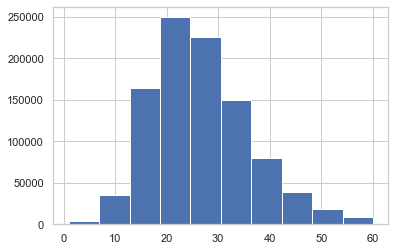

In [267]:
plt.hist(np.sqrt(trips['trip_duration']))

(array([1.81000e+02, 5.97000e+02, 7.44000e+02, 1.43900e+03, 2.86700e+03,
        2.00260e+04, 1.35785e+05, 3.69738e+05, 3.50815e+05, 9.22170e+04]),
 array([0.        , 0.81903544, 1.63807088, 2.45710632, 3.27614176,
        4.0951772 , 4.91421264, 5.73324808, 6.55228352, 7.37131896,
        8.1903544 ]),
 <BarContainer object of 10 artists>)

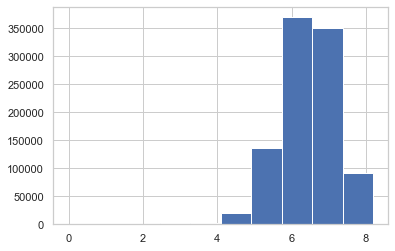

In [268]:
plt.hist(np.log(trips['trip_duration']))

- We can clearly see that the sqrt transformation is giving nearly normal distribution, there for we can choose the sqrt transformation on the dependent(trip_duration) variable.

### Splitting the data into train and test

In [269]:
# separates the whole feature matrix into train data feature matrix, 
# train data labels, and test data feature matrix 
X_train, y_train, X_test, y_test = get_train_test_fm(feature_matrix1,.75)
y_train = np.sqrt(y_train)
y_test = np.sqrt(y_test)

### Defining function for to check the performance of the model. 

In [270]:
#RMSE
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())

# MAE
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))


# Model Performance on test and train data
def model_pref(model, x_train, x_test, y_train,y_test):

    # Insample Prediction
    y_pred_train = model.predict(x_train)
    y_observed_train = y_train

    # Prediction on test data
    y_pred_test = model.predict(x_test)
    y_observed_test = y_test

    print(
        pd.DataFrame(
            {
                "Data": ["Train", "Test"],
                'RSquared':
                    [r2_score(y_observed_train,y_pred_train),
                    r2_score(y_observed_test,y_pred_test )
                    ],
                "RMSE": [
                    rmse(y_pred_train, y_observed_train),
                    rmse(y_pred_test, y_observed_test),
                ],
                "MAE": [
                    mae(y_pred_train, y_observed_train),
                    mae(y_pred_test, y_observed_test),
                ],
            }
        )
    )

#### Question 4.3 Build Linear regression using only weekend transform primitive

In [271]:
#Remove _________ and complete the code

#defining the model

lr1=LinearRegression()

#fitting the model
lr1.fit(X_train, y_train)


LinearRegression()

#### Check the performance of the model

In [272]:
#Remove _________ and complete the code
model_pref(lr1, X_train, X_test, y_train, y_test)  

    Data  RSquared      RMSE       MAE
0  Train  0.576106  6.132169  4.736641
1   Test  0.555831  6.558806  5.024874


**Write your answers here:**

Test data:
- R-squared is 0.56, slightly lower than for the training data
- RMSE is 6.56, higher than that of the training data
- MAE is 5.02, higher than that of the training data

Given the above observations, it can be said that the model is slightly (but not too drastically) overfitting. 

#### Question 4.4 Building decision tree using only weekend transform primitive

In [273]:
#Remove _________ and complete the code

#define the model
dt=DecisionTreeRegressor()

#fit the model

dt.fit(X_train, y_train)

DecisionTreeRegressor()

#### Check the performance of the model

In [274]:
#Remove _________ and complete the code
model_pref(dt, X_train, X_test, y_train, y_test)  

    Data  RSquared      RMSE       MAE
0  Train  0.917069  2.712331  1.518055
1   Test  0.597426  6.244153  4.638653


**Write your answers here:**

Test data:
- R-squared is 0.60, significantly lower than for the training data
- RMSE is 6.24, significantly higher than that of the training data
- MAE is 4.64, significantly higher than that of the training data

Given the above observations, it can be said that the model is suffering from strong overfitting. This is despite the test data R-squared, RMSE and MAE being better than that of the Linear Regression. Pruning the decision tree could reduce overfitting.  


#### Question 4.5 Building Pruned decision tree using only weekend transform primitive

In [275]:
#Remove _________ and complete the code
#define the model

#use max_depth=7
dt_pruned=DecisionTreeRegressor(max_depth=7)

#fit the model
dt_pruned.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=7)

#### Check the performance of the model

In [276]:
#Remove _________ and complete the code
model_pref(dt_pruned, X_train, X_test, y_train, y_test)  

    Data  RSquared      RMSE       MAE
0  Train  0.733766  4.859783  3.708634
1   Test  0.704190  5.352503  4.049448


**Write your answers here:**

Test data:
- R-squared is 0.70, only slightly lower than for the training data
- RMSE is 5.35, slighty higher than that of the training data
- MAE is 4.05, slighty higher than that of the training data

Given the above observations, it can be said that the pruned decision tree model is a significant improvement over the unpruned version. Moreover, despite there still being some minor overfitting present, compared to the Linear Regression test data results:
- R-squared is by ~ 0.15 better
- RMSE is by ~ 1.2 lower 
- MAE is by ~ 0.97 lower

This indicates that the pruned Decision Tree is a better model than the Regression Model.

Also, please note that although the exercise asks for a tree depth of 7, a depth of 13 produces the best test data results of: R-squared = 0.73, RMSE = 5.14 and MAE = 3.85. This however starts to suffer from more overfitting as the difference between training and test data R-squared increases from 2.9% to 4.6% as we increase depth from 7 to 13. Increasing the depth to a higher number than 13 causes a deterioration in the R-squared, RMSE and MAE.

#### Question 4.6 Building Random Forest using only weekend transform primitive

In [277]:
#Remove _________ and complete the code

#define the model

#using (n_estimators=60,max_depth=7)

rf=RandomForestRegressor(n_estimators=60,max_depth=7)

In [278]:
#fit the model

#Remove _________ and complete the code
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### Check the performance of the model

In [279]:
#Remove _________ and complete the code

model_pref(rf, X_train, X_test, y_train, y_test)

    Data  RSquared      RMSE       MAE
0  Train  0.738265  4.818549  3.676261
1   Test  0.708235  5.315778  4.019578


**Write your answers here:**

Test data:
- R-squared is 0.71, only slightly lower than for the training data
- RMSE is 5.31, slighty higher than that of the training data
- MAE is 4.02, slighty higher than that of the training data

Given the above observations, it can be said that the random forest is an even further improvement over the pruned decision tree. 

### Step 4: Adding more Transform Primitives and creating new model

* Add ``Minute``, ``Hour``, ``Month``, ``Weekday`` , etc primitives
* All these transform primitives apply to ``datetime`` columns

### Question 5: Create models with more transform primitives (10 Marks)

**Question 5.1 Define more transform primitives and define features using dfs?**

In [280]:
#Remove _________ and complete the code
trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]

#Remove _________ and complete the code
features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [281]:
print ("Number of features: %d" % len(features))
features

Number of features: 23


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

Now let's compute the features. 

**Question: 5.2 Compute features and define feature matrix**

In [282]:
#Remove _________ and complete the code
feature_matrix2 = compute_features(features, cutoff_time)

Elapsed: 00:06 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████
Finishing computing...


In [283]:
feature_matrix2.shape

(920378, 41)

In [284]:
feature_matrix2.head()

,WEEKDAY(pickup_datetime),trip_duration,MINUTE(pickup_datetime),DAY(dropoff_datetime),payment_type,IS_WEEKEND(dropoff_datetime),pickup_neighborhoods.latitude,DAY(pickup_datetime),dropoff_neighborhood = AD,dropoff_neighborhood = A,...,HOUR(dropoff_datetime),dropoff_neighborhoods.latitude,vendor_id,MINUTE(dropoff_datetime),MONTH(dropoff_datetime),dropoff_neighborhoods.longitude,trip_distance,MONTH(pickup_datetime),WEEKDAY(dropoff_datetime),HOUR(pickup_datetime)
id,,,,,,,,,,,,,,,,,,,,,
56311,1,645.0,0,12,1,False,40.720245,12,False,False,...,0,40.721435,2,11,1,-73.998366,1.61,1,1,0
56312,1,1270.0,2,12,2,False,40.646194,12,False,False,...,0,40.715828,2,23,1,-73.954298,16.15,1,1,0
56313,1,207.0,2,12,1,False,40.818445,12,False,False,...,0,40.818445,1,5,1,-73.948046,0.80,1,1,0
56314,1,214.0,2,12,2,False,40.729652,12,False,False,...,0,40.742531,2,6,1,-73.977943,1.33,1,1,0
56315,1,570.0,3,12,1,False,40.793597,12,False,False,...,0,40.818445,2,13,1,-73.948046,2.35,1,1,0


### Build the new models more transform features

In [289]:
# separates the whole feature matrix into train data feature matrix,
# train data labels, and test data feature matrix 
X_train2, y_train2, X_test2, y_test2 = get_train_test_fm(feature_matrix2,.75)
y_train2 = np.sqrt(y_train2)
y_test2 = np.sqrt(y_test2)

#### Question 5.3 Building Linear regression using more transform primitive

In [290]:
#Remove _________ and complete the code

#defining the model

lr2=LinearRegression()

#fitting the model
lr2.fit(X_train2, y_train2)


LinearRegression()

#### Check the performance of the model

In [291]:
#Remove _________ and complete the code
model_pref(lr2, X_train2, X_test2, y_train2, y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.623501  5.779195  4.273127
1   Test  0.623651  6.037346  4.537582


**Write your answers here:**

Test Data:

- R-squared is 0.62, very slightly higher than for the training data
- RMSE is 6.04, slightly higher than that of the training data
- MAE is 4.54, slightly higher than that of the training data

This linear regression is a clear improvement over the similar model with only 1 transform primitive. This is not only because all of the test data performance metrics are better, but also because the difference in those metrics between training and test datasets is a lot smaller. In fact the R-squared is actually 0.015% higher for the test data. 

#### Question 5.4 Building Decision tree using more transform primitive

In [292]:
#Remove _________ and complete the code

#define the model
dt2=DecisionTreeRegressor()

#fit the model

dt2.fit(X_train2, y_train2)

DecisionTreeRegressor()

#### Check the performance of the model

In [293]:
#Remove _________ and complete the code
model_pref(dt2, X_train2, X_test2, y_train2, y_test2)    

    Data  RSquared      RMSE       MAE
0  Train  1.000000  0.001479  0.000004
1   Test  0.713607  5.266615  3.789094


**Write your answers here:**
Test Data:

- R-squared is 0.71, significantly lower than for the training data
- RMSE is 5.27, a lot higher than that of the training data
- MAE is 3.79, a lot higher than that of the training data

Given the above observations, it can be said that the model is suffering from strong overfitting. This is despite the test data R-squared, RMSE and MAE being better than that of the Linear Regression in 5.3 above. Pruning the decision tree could reduce overfitting.  

#### Question 5.5 Building Pruned Decision tree using more transform primitive

In [294]:
#Remove _________ and complete the code
#define the model

#use max_depth=7
dt_pruned2=DecisionTreeRegressor(max_depth=7)

#fit the model
dt_pruned2.fit(X_train2, y_train2)

DecisionTreeRegressor(max_depth=7)

#### Check the performance of the model

In [295]:
#Remove _________ and complete the code
model_pref(dt_pruned2, X_train2, X_test2, y_train2, y_test2)      

    Data  RSquared      RMSE       MAE
0  Train  0.768105  4.535566  3.423759
1   Test  0.745845  4.961350  3.698053


## **Write your answers here:**

Test data:
- R-squared is 0.75, only slightly lower than for the training data
- RMSE is 4.96, slighty higher than that of the training data
- MAE is 3.70, slighty higher than that of the training data

Given the above observations, it can be said that the pruned decision tree model is a significant improvement over the unpruned version. Moreover, despite there still being some minor overfitting present, compared to the Linear Regression test data results:
- R-squared is by ~ 0.12 better
- RMSE is by ~ 1.1 lower 
- MAE is by ~ 0.8 lower

This re-proves that the pruned Decision Tree is a better model than the Regression Model.

Again, a depth of 13 or 14 gets better overall test data performance metrics than a depth of 7. However overfitting again starts to increase as the difference between training and test data R-squared increases from 2.2% to 4.8% as we increase depth from 7 to 14 with R-squared deteriorating for higher depths.

#### Question 5.6 Building Random Forest using more transform primitive

In [296]:
#fit the model

#Remove _________ and complete the code
#using (n_estimators=60,max_depth=7)

rf2 = RandomForestRegressor(n_estimators=60,max_depth=7)

#fit the model

#Remove _________ and complete the code
rf2.fit(X_train2, y_train2)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### Check the performance of the model

In [297]:
#Remove _________ and complete the code
model_pref(rf2, X_train2, X_test2, y_train2, y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.774642  4.471179  3.366930
1   Test  0.751791  4.902971  3.645133


**Write your answers here:**

Test data:
- R-squared is 0.75, only slightly lower than for the training data
- RMSE is 4.90, slighty higher than that of the training data
- MAE is 3.65, slighty higher than that of the training data

Given the above observations, it can be said that the random forest is an even further improvement over the pruned decision tree. 


**Question: 5.7 Comment on how the modeling accuracy differs when including more transform features.**

**Write your answers here:**

For all of the models (Linear Regression, Decision Tree, Pruned Decision Tree and Random Forest):

- R-squared of the test data is higher when more transform features are included
- RMSE and MAE are both lower when more transform features are included
- Difference between the training and test data R-squared, RMSE and MAE performance metrics reduced when more transform features were included. Thus reducing overfitting.

### Step 5: Add Aggregation Primitives

Now let's add aggregation primitives. These primitives will generate features for the parent entities ``pickup_neighborhoods``, and ``dropoff_neighborhood`` and then add them to the trips entity, which is the entity for which we are trying to make prediction.

### Question 6: Create a Models with transform and aggregate primitive. (10 Marks)
**6.1 Define more transform and aggregate primitive and define features using dfs?**

In [298]:
#Remove _________ and complete the code

trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [299]:
print ("Number of features: %d" % len(features))
features

Number of features: 61


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: pickup_neighborhoods.COUNT(trips)>,
 <Feature: pickup_neighborhoods.MAX(trips.passenger_count)>,
 <Feature: pickup_neighborhoods.MAX(trips.trip_distance)>,
 <Feature:

**Question: 6.2 Compute features and define feature matrix**

In [300]:
#Remove _________ and complete the code
feature_matrix3 = compute_features(features, cutoff_time)

Elapsed: 00:17 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████
Finishing computing...


In [301]:
feature_matrix3.head()

,MINUTE(dropoff_datetime),dropoff_neighborhoods.MEDIAN(trips.passenger_count),dropoff_neighborhood = AD,dropoff_neighborhood = A,dropoff_neighborhood = AA,dropoff_neighborhood = D,dropoff_neighborhood = AR,dropoff_neighborhood = C,dropoff_neighborhood = O,dropoff_neighborhood = N,...,pickup_neighborhood = D,pickup_neighborhood = A,pickup_neighborhood = AR,pickup_neighborhood = AK,pickup_neighborhood = AO,pickup_neighborhood = N,pickup_neighborhood = O,pickup_neighborhood = R,pickup_neighborhoods.SUM(trips.trip_distance),pickup_neighborhoods.MEAN(trips.trip_distance)
id,,,,,,,,,,,,,,,,,,,,,
56311,11,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,3904.70,3.008243
56312,23,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,19468.13,15.574504
56313,5,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,625.38,2.868716
56314,6,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,3891.78,2.285250
56315,13,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,2524.92,2.147041


### Build the new models more transform and aggregate features

In [302]:
# separates the whole feature matrix into train data feature matrix,
# train data labels, and test data feature matrix 
X_train3, y_train3, X_test3, y_test3 = get_train_test_fm(feature_matrix3,.75)
y_train3 = np.sqrt(y_train3)
y_test3 = np.sqrt(y_test3)

#### Question 6.3 Building  Linear regression model with transform and aggregate primitive.

In [303]:
#Remove _________ and complete the code

#defining the model

lr3=LinearRegression()

#fitting the model
lr3.fit(X_train3, y_train3)


LinearRegression()

#### Check the performance of the model

In [304]:
#Remove _________ and complete the code
model_pref(lr3, X_train3, X_test3, y_train3, y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  0.643423  5.624220  4.134927
1   Test  0.631697  5.972457  4.464424


**Write your answers here:**

Test Data:

- R-squared is 0.63, very slightly lower than for the training data
- RMSE is 5.97, slightly higher than that of the training data
- MAE is 4.46, slightly higher than that of the training data
- Overfitting virtually does not exist here

Compared to the linear regression model using just transform primivites, the R-squared of the test data is higher, and the RMSE and MAE is lower when both transform and aggregate primitives are used.

#### Question 6.4 Building  Decision tree with transform and aggregate primitive.

In [305]:
#Remove _________ and complete the code

#define the model
dt3=DecisionTreeRegressor()

#fit the model

dt3.fit(X_train3, y_train3)

DecisionTreeRegressor()

#### Check the performance of the model

In [306]:
#Remove _________ and complete the code
model_pref(dt3, X_train3, X_test3, y_train3, y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  1.000000  0.001479  0.000004
1   Test  0.648706  5.832915  4.190501


**Write your answers here:**

Test Data:

- R-squared is 0.65, significantly lower than for the training data
- RMSE is 5.83, a lot higher than that of the training data
- MAE is 4.19, a lot higher than that of the training data

Given the above observations, it can be said that the model is suffering from strong overfitting. Interesting to note is that these performance metrics are worse than for the unpruned decision tree that used only transform primitives (in 5.4 above). This might indicate that when many more features are present, overfitting becomes more serious for unpruned decision trees. 

#### Question 6.5 Building  Pruned Decision tree with transform and aggregate primitive.

In [307]:
#Remove _________ and complete the code
#define the model

#use max_depth=7
dt_pruned3=DecisionTreeRegressor(max_depth=7)

#fit the model
dt_pruned3.fit(X_train3, y_train3)

DecisionTreeRegressor(max_depth=7)

#### Check the performance of the model

In [308]:
#Remove _________ and complete the code
model_pref(dt_pruned3, X_train3, X_test3, y_train3, y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  0.769212  4.524722  3.418452
1   Test  0.745722  4.962549  3.696122


**Write your answers here:**

Test data:
- R-squared is 0.75, only slightly lower than for the training data
- RMSE is 4.96, slighty higher than that of the training data
- MAE is 3.70, slighty higher than that of the training data

Given the above observations, it can be said that the pruned decision tree model is a significant improvement over the unpruned version. It is also an improvement over the linear regression.

Interesting to note is that the above test data results are almost identical to those of the pruned decision tree using only transform primitives. Therefore adding aggregate primitives did not improve the pruned decision tree results.

#### Question 6.6 Building  Random Forest with transform and aggregate primitive.

In [309]:
#fit the model

#Remove _________ and complete the code
#using (n_estimators=60,max_depth=7)

rf3 = RandomForestRegressor(n_estimators=60,max_depth=7)

#fit the model

#Remove _________ and complete the code
rf3.fit(X_train3, y_train3)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### Check the performance of the model

In [310]:
model_pref(rf3, X_train3, X_test3, y_train3, y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  0.776521  4.452501  3.354643
1   Test  0.753109  4.889936  3.633362


**Write your answers here:**

Test data:
- R-squared is 0.75, only slightly lower than for the training data
- RMSE is 4.89, slighty higher than that of the training data
- MAE is 3.63, slighty higher than that of the training data

Given the above observations, it can be said that the random forest is an even further improvement over the pruned decision tree even in this case. However this is only a small improvement compared to the random forest that does not use aggregate features.



**Question 6.7 How do these aggregate transforms impact performance? How do they impact training time?**

**Write your answers here:**

Adding aggregate transforms:

- Did not signficantly improve performance (across Linear Regression, Pruned Decision Trees and Random Forests)
- Increased the time required to train the model

#### Based on the above 3 models, we can make predictions using our model2, as it is giving almost same accuracy as model3 and also the training time is not that large as compared to model3

In [311]:
y_pred = rf2.predict(X_test2)
y_pred = y_pred**2 # undo the sqrt we took earlier
y_pred[5:]

array([ 528.98474395,  215.79232445,  663.81910876, ...,  182.07380292,
       1028.99455389, 1759.33222947])

### Question 7: What are some important features based on model2 and how can they affect the duration of the rides? (3 Marks)

In [312]:
feature_importances(rf2, feature_matrix2.drop(['trip_duration'],axis=1).columns, n=10)

1: Feature: trip_distance, 0.910
2: Feature: HOUR(dropoff_datetime), 0.036
3: Feature: HOUR(pickup_datetime), 0.019
4: Feature: dropoff_neighborhoods.latitude, 0.016
5: Feature: pickup_neighborhoods.longitude, 0.003
6: Feature: WEEKDAY(dropoff_datetime), 0.003
7: Feature: IS_WEEKEND(dropoff_datetime), 0.003
8: Feature: WEEKDAY(pickup_datetime), 0.003
9: Feature: vendor_id, 0.002
10: Feature: IS_WEEKEND(pickup_datetime), 0.002


**Write your answers here:**

- The most significant feature is Trip Distance with 0.91. This makes logical sense as a longer distance takes a longer time to cover.
- Features 2 and 3 represent the hour of pickup and drop-off, implying a relationship between the hour of the day and the duration of the trip (maybe rush hour creates traffic jams, slowing down the average taxi speed - however this hypothesis would need an investigation of its own!).
- Feature 4 represents the location of the drop-off, implying a relationship between location and trip duration (perhaps certain drop-off locations are further away from the city centre itself, like the J. K. Airport, that is to the East (latitude) of the city and people are in a hurry to get there by taxi rather taking the train).